## Metropolis Hastings Random Walk on Graphs 

We're  going to build a slighly simpler notion of graph here than in part 1. Firstly its going to be bidirectional so a connection between nodes a and b corresponds to a connection between b and a. Instead of building a graph out of text i'm going to instead build one by taking a collection of nodes and then connecting each with some probability, we're also going to assume the weights on a single node are equally distrubuted. So for any random walker moving on this graph if its in a particular state and that state is connected to $n$ other states then the probability that the walker moves to each of those states is $1/n$

The following wall of code (sorry) is basically the same as in part 1 except the `TransitionMartix` matrix multiplication method now has an extra case included for a new class i've defined called `MetropolisWalker`. This way the matrix is applied differently to Metropolis Walkers than to normal walkers.

In [10]:
import random
import numpy as np
import matplotlib.pyplot as plt
import math


# For running random walks on the graph
class Walker:
    def __init__(self, state):
        self.state = state
        

# For running metropolos hastings algorithm on the graph
class MetropolisWalker:
    def __init__(self, state):
        self.state = state


# Abstaction of single state such as in the Walker class to a distrubution of states.
class State:
    def __init__(self, states):
        self.states = {state: 0  for state in states}
        
    def draw(self):
        people = self.states.keys()
        density = [self.states[person] for person in people]
        y_pos = np.arange(len(people))
#         density.sort(reverse = True)
        plt.bar(y_pos, density, align='center', alpha=0.5)
        plt.ylabel('density')
        plt.title('Node Visiting Rates')
        plt.show()

    @classmethod
    def from_orbit(cls, orbit):
        instance = cls(orbit)
        for point in orbit:
            instance.states[point] = instance.states.get(point, 0) + 1
        for key, value in instance.states.items():
            instance.states[key] = instance.states[key]/len(orbit) 
        return instance

    @classmethod
    def from_uniform(cls, states):
        instance = cls(states)
        for key, value in instance.states.items():
            instance.states[key] = 1/len(instance.states) 
        return instance
    
    def __sub__(self, other):
        difference = State(self.states.keys())
        for key, _ in difference.states.items():
            difference.states[key] = abs(self.states.get(key, 0) - other.states.get(key, 0))
        return difference
    
    def dist(self, other):
        diff = other - self
        return math.sqrt(sum([v**2 for _, v in diff.states.items()]))


# Going to map between states with this class
class TransitionMatrix:
    def __init__(self, states):
        self.p = {state: {} for state in states}
        
    @classmethod
    def uniform_bidirected(cls, states, alpha):
        instance = cls(states)
        for key, node in instance.p.items():
            num_connections = random.randint(0, len(instance.p))
            connections = random.sample(instance.p.keys(), num_connections)
            for c in connections:
                if random.random() > alpha:
                    instance.p[key][c] = 1
                    instance.p[c][key] = 1
        instance._normalize()
        return instance
        
    def _normalize(self):
        for key, val in self.p.items():
            row_total = sum([count for _, count in val.items()])
            for target, count in val.items():
                self.p[key][target] = self.p[key][target]/row_total

        
    def __matmul__(self, other):
        """If applying the transistion matrix class to a Walker class then select the next state at random. 
        If applying to a State class we generate a new distrbution. """

        if isinstance(other, State):
            new_state = State([s for s, _ in other.states.items()])
            for s_1, p in other.states.items():
                sum_p_s2_s1 = 0
                for s_2, P in self.p.items():
                    sum_p_s2_s1 = sum_p_s2_s1 + other.states[s_2]*P.get(s_1, 0)
                new_state.states[s_1] = sum_p_s2_s1 
            return new_state

        if isinstance(other, Walker):
            ps = self.p[other.state]
            choices = [*ps.keys()]
            weights = [*ps.values()]
            choice = random.choices(choices, weights=weights).pop()
            return Walker(choice)
        
        if isinstance(other, MetropolisWalker):
            ps = self.p[other.state]
            choices = [*ps.keys()]
            weights = [*ps.values()]
            choice = random.choices(choices, weights=weights).pop()

            p_c_s = self.p[choice][other.state]
            p_s_c = self.p[other.state][choice]
            p_a = random.random()

            if p_a < min(1, p_c_s/p_s_c):
                return MetropolisWalker(choice)
            else:
                return MetropolisWalker(other.state)
    


## The Metropoplis Hastings Algorithm

___


The Metropoplis Hasting Algorithm is a random walk on the graph that aims to obtain a representative sample of the graphs node independent of there connectivity. In a typical random walk a walker on a node `a` goes to a node `b` with probability $1/n_{a}$ where $n_{a}$ is the number of nodes to which `a` is connected. The Metropoloplis Hasting Algorithm is a random walk but where the probabailities have been adjusted. It works like so:

1. On node `a` pick a connected node `b` at random. 
2. Let $p_{a,b}$ be the probabiltiy of  going from `a` to `b`. This will be $1/n_{a}$. Let $p_{b,a}$ be the  probability of going from `b` to `a`, or $1/n_{b}$. 
3. Let $p$ be the minimum of $1$ and $ \frac{p_{a,b}}{p_{b,a}} $ 
4. With probability $p$ go from `a` to `b` otherwise stay at `a`
5. Repeat

The trick here happens at point 3. If $p_{a,b}$ is greater that $p_{b,a}$ then you go to `b` with probability 1. So if `a` is less connected than `b`... By making this adjustment you reverse the natural tendency for random walks in graphs to visit highly connected nodes more than less connected nodes.

It's slightly hard to believe this works. Lets look first at the numerical simulations and see what happends:

## Numerical Simulations:

___


Below we model a network made up of 500 nodes that represent people. The graph displays the number of social links per person

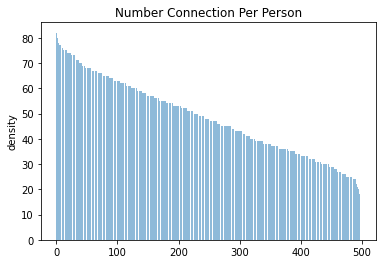

In [3]:
from faker import Faker
fake = Faker()

states = [fake.name() for _ in range(500)]
T = TransitionMatrix.uniform_bidirected(states, 0.9)


people = T.p.keys()
num_friends = [len(T.p[person]) for person in people]
y_pos = np.arange(len(people))
num_friends.sort(reverse = True)
plt.bar(y_pos, num_friends, align='center', alpha=0.5)
plt.ylabel('density')
plt.title('Number Connection Per Person')
plt.show()

Lets see what happens now if run a random walker orbit on the network. The graph displayed shows the rates at which the orbit visits each node. As you can see it's not uniform and some nodes are visited far more than others.

Node Visiting Rates:  0.013756605858492924


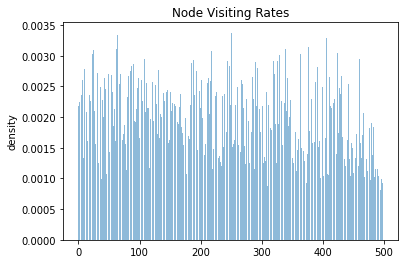

In [11]:
uniform = State.from_uniform(states)

person = random.choice(states)
orbit = [Walker(person)]

for i in range(3000000):
    orbit.append(T@orbit[-1])

orbit_dist = State.from_orbit([o.state for o in orbit])

print('Node Visiting Rates: ', orbit_dist.dist(uniform))
orbit_dist.draw()

Now instead of a normal random walk lets try a metropolis hastings random walk and see what we get: 

distance from uniform:  0.0007634611742639561


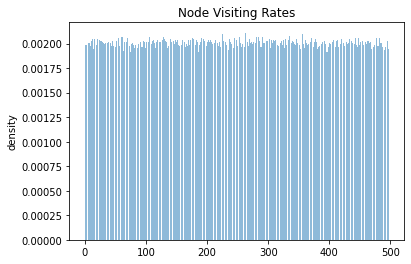

In [12]:
person = random.choice(states)

orbit = [MetropolisWalker(person)]

for i in range(3000000):
    orbit.append(T@orbit[-1])

orbit_dist = State.from_orbit([o.state for o in orbit])

print('distance from uniform: ', orbit_dist.dist(uniform))
orbit_dist.draw()

So as you can see the metropolosis hastings random walk looks like it's converging to the uniform distrubution. This means that the orbit is visiting the nodes representativly instead of being biased towards nodes which greater numbers of connections. We can compare the orbits more explicitly (__Warning__: If your running the following it will take a long time and is not the best way of doing this):

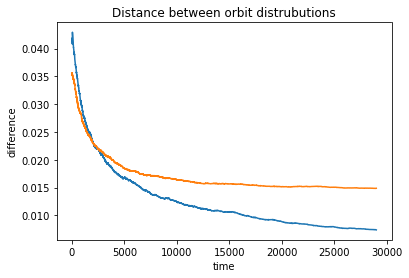

Normal walker: 0.0073974708134618376
Metropolis walker: 0.014881319869752028


In [13]:
person = random.choice(states)
uniform = State.from_uniform(states)

orbit_1 = [MetropolisWalker(person)]
orbit_2 = [Walker(person)]

differences_1 = []
differences_2 = []

for i in range(30000):
    orbit_1.append(T@orbit_1[-1])
    orbit_2.append(T@orbit_2[-1])
    orbit_dist_1 = State.from_orbit([o.state for o in orbit_1])
    orbit_dist_2 = State.from_orbit([o.state for o in orbit_2])
    differences_1.append(orbit_dist_1.dist(uniform))
    differences_2.append(orbit_dist_2.dist(uniform))

plt.plot(differences_1[1000:]) # metropolis walker
plt.plot(differences_2[1000:]) # normal walker
plt.title('Distance between orbit distrubutions')
plt.ylabel('difference')
plt.xlabel('time')
plt.show()

print('Normal walker: {}'.format(differences_1[-1]))
print('Metropolis walker: {}'.format(differences_2[-1]))

The blue line above shows the convergence of the metropolis walker towards the uniform distrubution while the orange is the normal random walker. You can clearly see that the orange line is bounded away from zero wheras the metropolis walker is convergent.  